In [1]:
import os
import shutil
import utilities as rocku
import matplotlib.pyplot as plt
import tomopy
import numpy as np
import pandas as pd
import pprint
import dxchange
import multiprocessing as mp
import timeit
from tqdm import tqdm

In [2]:
ncore = mp.cpu_count()
ncore

64

In [3]:
# need to change
ipts="31474"
# scan_type = 'ct_scans'
scan_type = 'radiographs'
# scan_type = 'alignment_calibration'

In [4]:
scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/" + scan_type
sorted(os.listdir(scan_loc))

['2024_06_24_density_post_irradiation',
 '2024_06_24_density_post_irradiation_restart_at_700C']

In [5]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
sorted(os.listdir(ob_loc))

['2024_06_24_OB_60s']

In [6]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/dc"
sorted(os.listdir(dc_loc))

['2024_06_20_DC_60s']

In [7]:
###################### need to change start
sample_name = "2024_06_24_density_post_irradiation_restart_at_700C"
scan_dir = os.path.join(scan_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2024_06_24_OB_60s")
dc_dir = os.path.join(dc_loc, "2024_06_20_DC_60s")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
ob_name = "*OB*" # Will not be used if follows the default file structure
dc_name = "*DC*" # Will not be used if follows the default file structure
gamma_diff = 20
###################### need to change end

# Preprocess scan files

In [8]:
fname_list = os.listdir(scan_dir)
# fname_list.pop(0)
fname_list.sort()
print(len(fname_list))
fname_list

440


['08_heating_at_800_0060_0001.tiff',
 '08_heating_at_800_0060_0002.tiff',
 '08_heating_at_800_0060_0003.tiff',
 '08_heating_at_800_0060_0004.tiff',
 '08_heating_at_800_0060_0005.tiff',
 '08_heating_at_800_0060_0006.tiff',
 '08_heating_at_800_0060_0007.tiff',
 '08_heating_at_800_0060_0008.tiff',
 '08_heating_at_800_0060_0009.tiff',
 '09_heat_hold_at_800_0060_0001.tiff',
 '09_heat_hold_at_800_0060_0002.tiff',
 '09_heat_hold_at_800_0060_0003.tiff',
 '09_heat_hold_at_800_0060_0004.tiff',
 '09_heat_hold_at_800_0060_0005.tiff',
 '09_heat_hold_at_800_0060_0006.tiff',
 '09_heat_hold_at_800_0060_0007.tiff',
 '09_heat_hold_at_800_0060_0008.tiff',
 '09_heat_hold_at_800_0060_0009.tiff',
 '09_heat_hold_at_800_0060_0010.tiff',
 '09_heat_hold_at_800_0060_0011.tiff',
 '09_heat_hold_at_800_0060_0012.tiff',
 '09_heat_hold_at_800_0060_0013.tiff',
 '09_heat_hold_at_800_0060_0014.tiff',
 '09_heat_hold_at_800_0060_0015.tiff',
 '09_heat_hold_at_800_0060_0016.tiff',
 '09_heat_hold_at_800_0060_0017.tiff',
 '09

In [9]:
to_rmv = [
#     '20230919_dry_spun_fibers_0300_0013.tiff',
#  '20230919_dry_spun_fibers_0300_0014.tiff',
#  '20230919_dry_spun_fibers_0300_0015.tiff',
#  '20230919_dry_spun_fibers_rejoint_0300_0021.tiff',
#  '20230919_dry_spun_fibers_rejoint_0300_0022.tiff',
#  '20230919_dry_spun_fibers_rejoint_0300_0023.tiff',
#  '20230919_wet_spun_fibers_0300_0006.tiff',
#  '20230919_wet_spun_fibers_0300_0007.tiff',
#  '20230919_wet_spun_fibers_0300_0008.tiff',
]
fname_list = rocku.remove_fnames(fname_list, to_rmv)

440
440


In [10]:
ob_list = os.listdir(ob_dir)
# fname_list.pop(0)
ob_list.sort()
print(len(ob_list))
# ob_list = ob_list[:3]
ob_list

7


['OB_0060_7680.tiff',
 'OB_0060_7681.tiff',
 'OB_0060_7682.tiff',
 'OB_0060_7683.tiff',
 'OB_0060_7684.tiff',
 'OB_0060_7685.tiff',
 'OB_0060_7686.tiff']

In [11]:
to_rmv = [
# 'OB_0060_1578.tiff',
#  'OB_0060_1579.tiff',
#  'OB_0060_1580.tiff',
#  'OB_0060_1581.tiff',
#  'OB_0060_1582.tiff',
#  'OB_0060_1583.tiff',
#  'OB_0060_1584.tiff',
#  'OB_0060_1585.tiff',
#  'OB_0060_1586.tiff',
#  'OB_0060_1587.tiff',
#  'OB_0060_1588.tiff',
#  'OB_0060_1589.tiff',
#  'OB_0060_1590.tiff',
#  'OB_0060_1591.tiff',
#  'OB_0060_1592.tiff',
]
ob_list = rocku.remove_fnames(ob_list, to_rmv)

7
7


In [12]:
dc_list = os.listdir(dc_dir)
# fname_list.pop(0)
dc_list.sort()
print(len(dc_list))
dc_list

20


['DC_0060_2755.tiff',
 'DC_0060_2756.tiff',
 'DC_0060_2757.tiff',
 'DC_0060_2758.tiff',
 'DC_0060_2759.tiff',
 'DC_0060_2760.tiff',
 'DC_0060_2761.tiff',
 'DC_0060_2762.tiff',
 'DC_0060_2763.tiff',
 'DC_0060_2764.tiff',
 'DC_0060_2765.tiff',
 'DC_0060_2766.tiff',
 'DC_0060_2767.tiff',
 'DC_0060_2768.tiff',
 'DC_0060_2769.tiff',
 'DC_0060_2770.tiff',
 'DC_0060_2771.tiff',
 'DC_0060_2772.tiff',
 'DC_0060_2773.tiff',
 'DC_0060_2774.tiff']

In [13]:
to_rmv = [
#  'DC_0060_2903.tiff',
]
dc_list = rocku.remove_fnames(dc_list, to_rmv)

20
20


In [14]:
######### Scan
scan_raw = rocku.read_tiff_stack(scan_dir, fname_list)
print(scan_raw.shape)
######### OB
ob_raw = rocku.read_tiff_stack(ob_dir, ob_list)
print(ob_raw.shape)
######### DC
dc_raw = rocku.read_tiff_stack(dc_dir, dc_list)
print(dc_raw.shape)

440it [05:59,  1.22it/s]


(440, 6400, 6400)


7it [00:00, 19.23it/s]


(7, 6400, 6400)


20it [00:01, 18.48it/s]

(20, 6400, 6400)


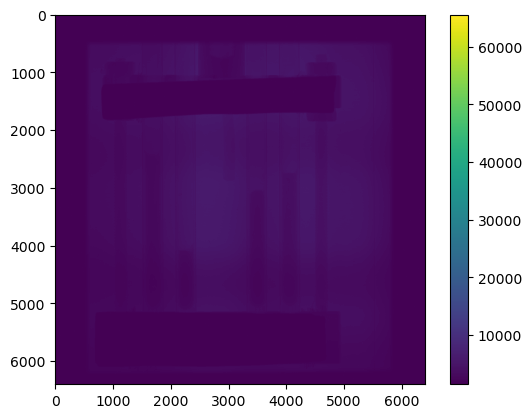

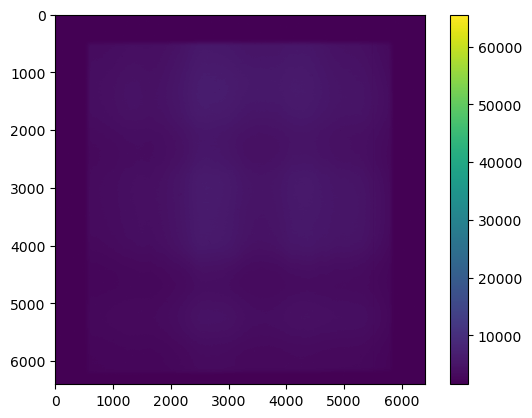

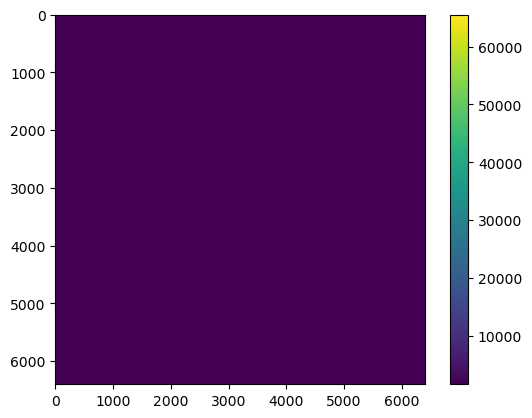

In [15]:
scan_min = np.min(scan_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
plt.imshow(scan_min)
plt.colorbar()
plt.show()
plt.imshow(ob_min)
plt.colorbar()
plt.show()
plt.imshow(dc_max)
plt.colorbar()
plt.show()

# Crop ROI

Recon ROI:


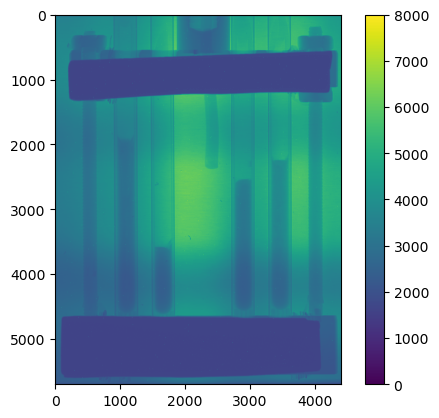

In [16]:
###################### need to change start
crop = True
# crop = True
crop_left = 600#320
crop_right = 5000#1080
crop_top = 500
crop_bottom = 6200
# crop_left = 2500
# crop_right = 4500
# crop_top = 200
# crop_bottom = 2350
###################### need to change end
scan_crop = rocku.crop(scan_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
scan_crop_min = rocku.crop(scan_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Recon ROI:")
plt.imshow(scan_crop_min, vmin=0, vmax=8000)
plt.colorbar()
plt.show()

# Removal outliers

In [17]:
t0 = timeit.default_timer()
scan_crop = tomopy.misc.corr.remove_outlier(scan_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Time: 296.0911825769581 s


# Bin images

In [18]:
bin_size = 1
#####################
#####################
if bin_size != 1:
    to_rmv = len(fname_list)%bin_size
    if to_rmv == 0:
        fname_list_rmv = fname_list[:]
        scan_crop_rmv = scan_crop[:]
    else:
        fname_list_rmv = fname_list[:-to_rmv]
        scan_crop_rmv = scan_crop[:-to_rmv]
    fname_list_bin = fname_list_rmv[0::bin_size]
    scan_crop_bin = np.array([np.mean(scan_crop_rmv[i:i+bin_size], axis=0) for i in tqdm(range(0, len(scan_crop_rmv), bin_size))]) 

# Normalization

OB stack combined by median.
DC stack combined by median.
Normalizing...
Normalization Done!
float32
(440, 5700, 4400)


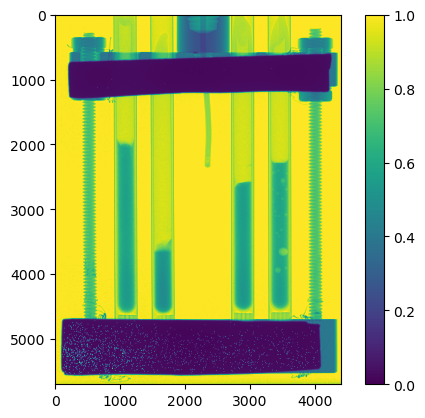

In [19]:
if bin_size != 1:
    scan_norm, ob_med, dc_med = rocku.normalize(scan_crop_bin, ob_crop, dc_crop)
else:
    scan_norm, ob_med, dc_med = rocku.normalize(scan_crop, ob_crop, dc_crop)
print(scan_norm.dtype)
print(scan_norm.shape)
plt.imshow(scan_norm[0], vmin=0, vmax=1)
# plt.imshow(scan_norm[0])
plt.colorbar()
plt.show()

# Beam fluctuation correction (optional)


Beam fluctuation ROI:


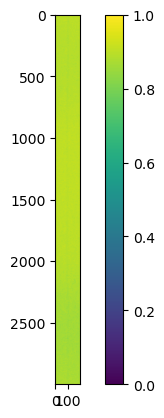

In [20]:
###################### need to change start
# bg_left = 30
# bg_right = 280
# bg_top = 2
# bg_bottom = 1400
bg_left = 0
bg_right = 200
bg_top = 1500
bg_bottom = 4500
###################### need to change end
bg_stack = scan_norm[:, bg_top:bg_bottom, bg_left:bg_right]
bg_min = np.min(bg_stack, axis=0)
print("Beam fluctuation ROI:")
plt.imshow(bg_min, vmin=0, vmax=1)
plt.colorbar()
plt.show()

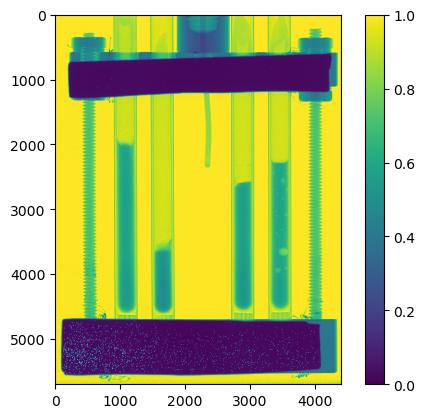

Time: 32.27615638123825 s


In [21]:
t0 = timeit.default_timer()
scan_norm = tomopy.prep.normalize.normalize_roi(scan_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
plt.imshow(scan_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Time: 82.25771248200908 s


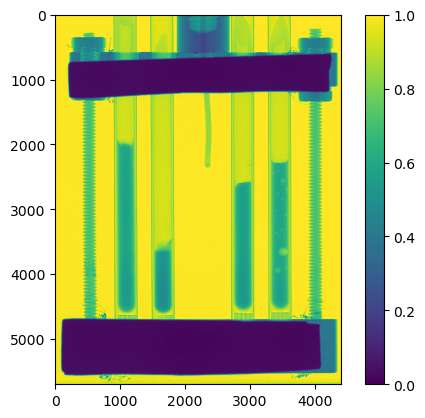

In [22]:
t0 = timeit.default_timer()
scan_norm = tomopy.misc.corr.remove_outlier(scan_norm, 0.1, ncore=ncore) 
t1 = timeit.default_timer() 
print("Time: {} s".format(t1-t0))
plt.imshow(scan_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Save files

In [23]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/normalized/" + sample_name# + '_Right'
if bin_size != 1:
    save_to = save_to + "_binned_by_" + str(bin_size)
    fname_list_save = fname_list_bin[:]
else:
    fname_list_save = fname_list[:]
print('Saving to {} ...'.format(save_to))
for i, e_name in tqdm(enumerate(fname_list_save)):
#     e_name = rocku.remove_1st_str(e_name)
    fname = save_to + "/" + e_name
    dxchange.write_tiff(scan_norm[i], fname=fname, overwrite=True)

Saving to /HFIR/CG1D/IPTS-31474/shared/processed_data/normalized/2024_06_24_density_post_irradiation_restart_at_700C ...


440it [01:42,  4.28it/s]
